<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4206_202510_AML/blob/main/Laboratorios/Laboratorio_4/MINE_4206_202510_AML_Lab4_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

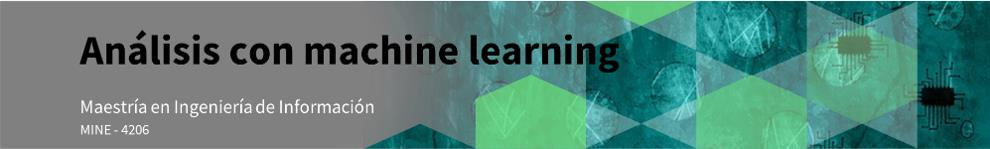

**Tutores**.
* Nicolás Tibatá Casteñeda.
* Fabián Camilo Castellanos P.

#Tabla de contenido

[Contexto y objetivos.](#scrollTo=BVDF0pJxyF2x)<br>
[0. Instalación e importación de librerías.](#scrollTo=DgecP31Sepks)<br>
[1. Carga de datos](#scrollTo=NhXcyVRRepkv)<br>
[2. Segmentación de imágenes](#scrollTo=XFSg44EyeplB)<br>
[2.1. Segmentación de imágenes con KMeans](#scrollTo=xscYq81jeplC)<br>
[2.2. Segmentación de imágenes con Mean Shift](#scrollTo=XlnsdKU2eplK)<br>
[3. Preguntas](#scrollTo=vlU1OeuPeplN)<br>

# Contexto y objetivos

**Un problema de segmentación de imágenes**

En este notebook verás una posible solución a un problema de segmentación de imágenes utilizando los algoritmos KMeans y Mean Shift. En particular, se cargará un conjunto de datos de imágenes con tres canales de colores, y se mostrará la construcción de dos modelos de segmentación utilizando cada algoritmo, resultando en la generación de una paleta de colores para una imagen.

# 0. Instalación e importación de librerías

Importaremos las librerías `numpy`, `os` y `cv2` para la carga y procesamiento de las imágenes, así como la librería `scikit_learn` para usar los algoritmos de agrupación y la librería `matplotlib` para visualizar las imágenes resultantes:

In [ ]:
import numpy as np

import os
import cv2
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

# 1. Carga de datos

Definiremos una funcion `load_images()` para la carga de las imágenes. Esta función asume que se tiene un directorio o carpeta con las imágenes, y utiliza funciones como `imread()` y `cvtColor()` para realizar la carga y procesamiento de cada una:

In [ ]:
def load_images(root_path, file_names, flatten=True, normalize=True):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.

    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if flatten:
            img = img.reshape((-1, 3))
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list

In [ ]:
root_path = 'data'

In [ ]:
img_files = os.listdir(root_path)
img_files

['image 2.jpg', 'image 1.jpg']

Primero realizaremos la carga de las imágenes sin modificaciones, es decir, manteniendo tanto las dimensiones originales como los valores de píxeles:

In [ ]:
img_original = load_images(root_path, img_files, flatten=False, normalize=False)
img_original

[array([[[ 22,  25,  18],
         [ 22,  25,  18],
         [ 22,  25,  18],
         ...,
         [103,  86,  70],
         [102,  85,  69],
         [102,  85,  69]],
 
        [[ 23,  26,  19],
         [ 23,  26,  19],
         [ 23,  26,  19],
         ...,
         [103,  86,  70],
         [103,  86,  70],
         [103,  86,  70]],
 
        [[ 23,  26,  19],
         [ 23,  26,  19],
         [ 23,  26,  19],
         ...,
         [104,  87,  71],
         [104,  87,  71],
         [104,  87,  71]],
 
        ...,
 
        [[ 46,  40,  24],
         [ 45,  39,  23],
         [ 45,  40,  21],
         ...,
         [ 36,  43,  12],
         [ 35,  42,  11],
         [ 36,  43,  12]],
 
        [[ 44,  38,  24],
         [ 45,  39,  23],
         [ 47,  42,  23],
         ...,
         [ 40,  47,  16],
         [ 40,  47,  14],
         [ 41,  48,  15]],
 
        [[ 42,  36,  22],
         [ 44,  38,  22],
         [ 46,  40,  24],
         ...,
         [ 44,  51,  20],
  

Por otro lado, realizaremos la carga de las imágenes como una lista de píxeles, normalizando sus valores para que estén en el rango [0, 1]. Este será el conjunto de datos que utilizaremos para el entrenamiento de los modelos:

In [ ]:
img_list = load_images(root_path, img_files, flatten=True, normalize=True)
img_list

[array([[0.08627451, 0.09803922, 0.07058824],
        [0.08627451, 0.09803922, 0.07058824],
        [0.08627451, 0.09803922, 0.07058824],
        ...,
        [0.17254902, 0.2       , 0.07843137],
        [0.17647059, 0.20392157, 0.0745098 ],
        [0.18431373, 0.21176471, 0.08235294]]),
 array([[0.26666667, 0.51764706, 0.69019608],
        [0.26666667, 0.51764706, 0.69019608],
        [0.26666667, 0.51764706, 0.69019608],
        ...,
        [0.17254902, 0.38039216, 0.50196078],
        [0.17254902, 0.38039216, 0.50196078],
        [0.17254902, 0.38039216, 0.50196078]])]

Por ejemplo, las dimensiones de la imagen original son `(ancho, alto, canales)`, mientras que el conjunto de entrenamiento tiene dimensiones `(alto*ancho, canales)`:

In [ ]:
img_original[0].shape

(4000, 6000, 3)

In [ ]:
img_list[0].shape

(24000000, 3)

# 2. Segmentación de imágenes

En este notebook mostraremos dos posibles métodos para realizar la segmentación, empezando por el algoritmo KMeans:

## 2.1. Segmentación de imágenes con KMeans

En esta versión, primero debemos especificar el número de clústeres. Por ejemplo, realizaremos una segmentación con cinco clústeres:

In [ ]:
num_clusters = 5

Y aplicaremos el algoritmo sobre la imagen `img_list[1]`:

In [ ]:
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(img_list[1])

KMeans(n_clusters=5)

Podemos ver la paleta de colores resultante como los centroides encontrados por el modelo:

In [ ]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids

array([[0.33531363, 0.54560667, 0.65324474],
       [0.02714576, 0.07958161, 0.11800861],
       [0.47002494, 0.66282749, 0.76048441],
       [0.14319295, 0.32402591, 0.41949804],
       [0.22587157, 0.42608791, 0.53795909]])

Y podemos generar una máscara o imagen segmentada con la expresión `centroids[labels]`. Ten en cuenta que, para visualizar la imagen correctamente, reescalamos los valores de píxeles al rango original de [0, 255], y volvemos a las dimensiones originales con `reshape()`:

In [ ]:
img_segmented = centroids[labels]*255
img_segmented = img_segmented.reshape(img_original[1].shape)

A continuación puedes visualizar el resultado:

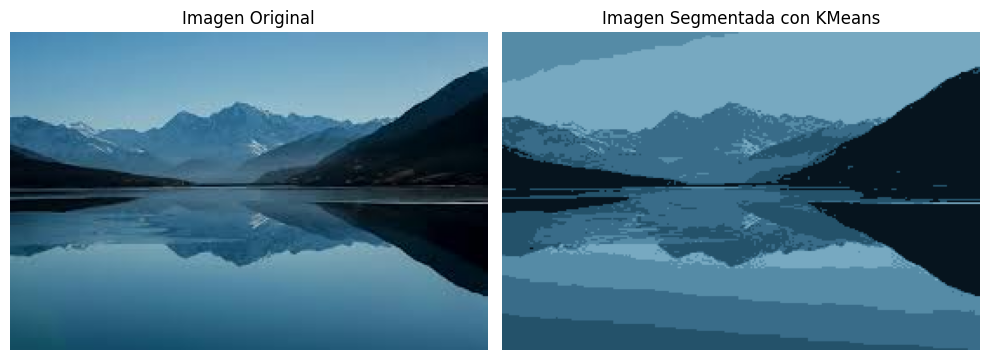

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_original[1])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Segmentada con KMeans')
plt.imshow(img_segmented.astype(np.uint8))
plt.axis('off')

plt.tight_layout()
plt.show()

## 2.2. Segmentación de imágenes con Mean Shift

El siguiente método, con el algoritmo Mean Shift, no necesita especificar el número de clústeres, pero sí necesita estimar una ventana:

In [ ]:
bandwidth = estimate_bandwidth(img_list[0], quantile=0.2, n_samples=100)

Con la ventana definida, aplicaremos el algoritmo sobre la imagen almacenada en `img_list[0]`:

In [ ]:
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(img_list[0])

MeanShift(bandwidth=np.float64(0.2075176430347306), bin_seeding=True)

Al igual que con KMeans, podemos ver la paleta de colores resultante como la lista de centroides:

In [ ]:
labels = meanshift.labels_
centroids = meanshift.cluster_centers_
centroids

array([[0.17205869, 0.19512528, 0.07798374],
       [0.5761441 , 0.47101566, 0.34756765],
       [0.91882093, 0.7102232 , 0.24862792]])

También generaremos la máscara o imagen segmentada para visualizar el resultado:

In [ ]:
img_segmented = centroids[labels]*255
img_segmented = img_segmented.reshape(img_original[0].shape)

La imagen original y el resultado se pueden observar a continuación:

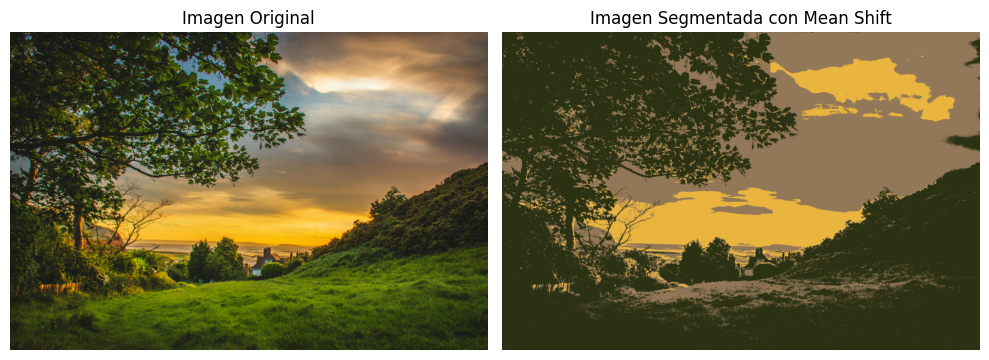

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_original[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Segmentada con Mean Shift')
plt.imshow(img_segmented.astype(np.uint8))
plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Preguntas

En este notebook viste una posible solución a un problema de segmentación utilizando los algoritmos KMeans y Mean Shift. En particular, observaste dos métodos que se diferencian en la definición del número de clústeres, generando una paleta de colores para una imagen particular. Ten en cuenta que el procesamiento y algoritmos utilizados no son los únicos que pueden dar solución a este problema, por lo que puedes utilizar otro tipo de procesamiento y algoritmos de agrupación diferentes para obtener diversos resultados.